# Conditional Gans Model Making Project 

* Conditional Gans Base Model을 만들기 위해 앞서 우선 제공된 GAN 모델을 활용하여 Condition을 삽입한 모델 Define 및 학습, 결과 확인
* Generator, Discriminator Model의 Layer를 Dense로 변형시키고 Condition을 추가한 모델 Define 및 학습, 결과 확인
* Generator, Discriminator Model의 Layer를 Conv로 변형시키고 Condition을 추가한 모델 Define 및 학습, 결과 확인

### Condition 추가 방법에 대한 이야기
Condition을 추가하기 위해 이전 VAE, AE과제에서 사용했던 방법을 참고해서 진행하고자 한다. 

* Generator에 Noise Data를 처음 삽입할때 형태가 [None, 100]의 형태이다. 
* Label을 Onehot 형태로 펼쳐서 작업을 진행할 예정이다.
* Generator에는 Condition을 삽입하기 위해 [None, 10]의 형태로 삽입하며 조건은 trian data에 있는 상위 50개의 train_label을 사용해서 변환을 하여 작업을 하고자 한다. (이때 Noise의 개수도 50개로 한정한다.)

Discriminator에는 Noise Data로 만든 [28,28] 형태의 데이터가 삽입되고 train_image의 형태인 [28,28] 형태로 데이터가 삽입된다. 이때 Condition을 삽입하기 위해서 28,28,1로 변환을 먼저 시키고 기존의 다른 Condition vae, Condition ae에서 만든 조건처럼 삽입하고자 한다. (28,28,10)의 형태로 Condition Data로 변환하여 마지막 3번째 차원의 값이 Condition을 의미하도록 작업해서 진행하고자 한다. 그후 input으로 들어온 데이터와 condition을 concat해서 판별기에 모델을 돌리는 작업을 진행하여 Conditional GAN모델을 완성시키고자 한다. 

Discriminator에는 Condition을 삽입하지 않은 모델을 만들어 보고자 한다. 그래서 Discriminator에 Condition을 삽입하였을 때와 삽입하지 않았을 때의 성능을 비교해 보고자 한다. 

## Condition Gan Base Model Define

In [0]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp

from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.

Python: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Numpy: 1.18.4
Tensorflow:  2.2.0
Keras:  2.3.0-tf
Tensorflow Probability:  0.10.0-rc0


In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [-1, 1] (* tanh을 거친 값과 비교해야 하기 때문...)
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

# tensorflow probablity layer가 float32를 입력을 받기 때문에 float64를 float32로 캐스팅
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# 데이터가 [-1, 1] 사이로 정규화 되었는지 확인
print(np.amin(train_images), np.amax(train_images))


print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels[0].dtype)

11493376/11490434 [==============================] - 0s 0us/step
-1.0 1.0
(60000, 28, 28)
(10000, 28, 28)
(28, 28)
float32
uint8


In [0]:
# 트레이닝 데이터 배치 사이즈 결정 및 셔플
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
train_label_datasets = tf.data.Dataset.from_tensor_slices(train_label_onehots).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# 데이터 변환 확인
print(train_label_onehots.shape)
print(train_label_onehots[0])
print(train_labels[0])

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5


In [0]:
def trans(x):
  a = np.ones((28,28,10))
  b = []
  for i in range(len(x)):
    b.append(x[i]*a)
  return b

train_label_onehot = np.array(trans(train_label_onehots))
train_label_dataset = tf.data.Dataset.from_tensor_slices(train_label_onehot).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
fake_img = tf.keras.Input(shape=(100,)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))

x = tf.keras.layers.concatenate([fake_img, con])
enc_dense_1 = tf.keras.layers.Dense(7*7*256, use_bias=False)(x)
enc_dense1 = layers.BatchNormalization()(enc_dense_1)
enc_dense2 = layers.LeakyReLU()(enc_dense1)
enc_dense3 = layers.Reshape(target_shape=(7,7,256))(enc_dense2)
enc_dense4 = layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False)(enc_dense3)
enc_dense5 = layers.BatchNormalization()(enc_dense4)
enc_dense6 = layers.LeakyReLU()(enc_dense5)
enc_dense7 = layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False)(enc_dense6)
enc_dense8 = layers.BatchNormalization()(enc_dense7)
enc_dense9 = layers.LeakyReLU()(enc_dense8)
enc_dense10 = layers.Conv2DTranspose( 1,(5,5),strides=(2,2),padding='same',use_bias=False, activation='tanh')(enc_dense9)
enc = layers.Reshape(target_shape=(28,28))(enc_dense10)

G = tf.keras.Model(inputs=[fake_img, con], outputs=enc)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 12544)        1379840     concatenate[0][0]            

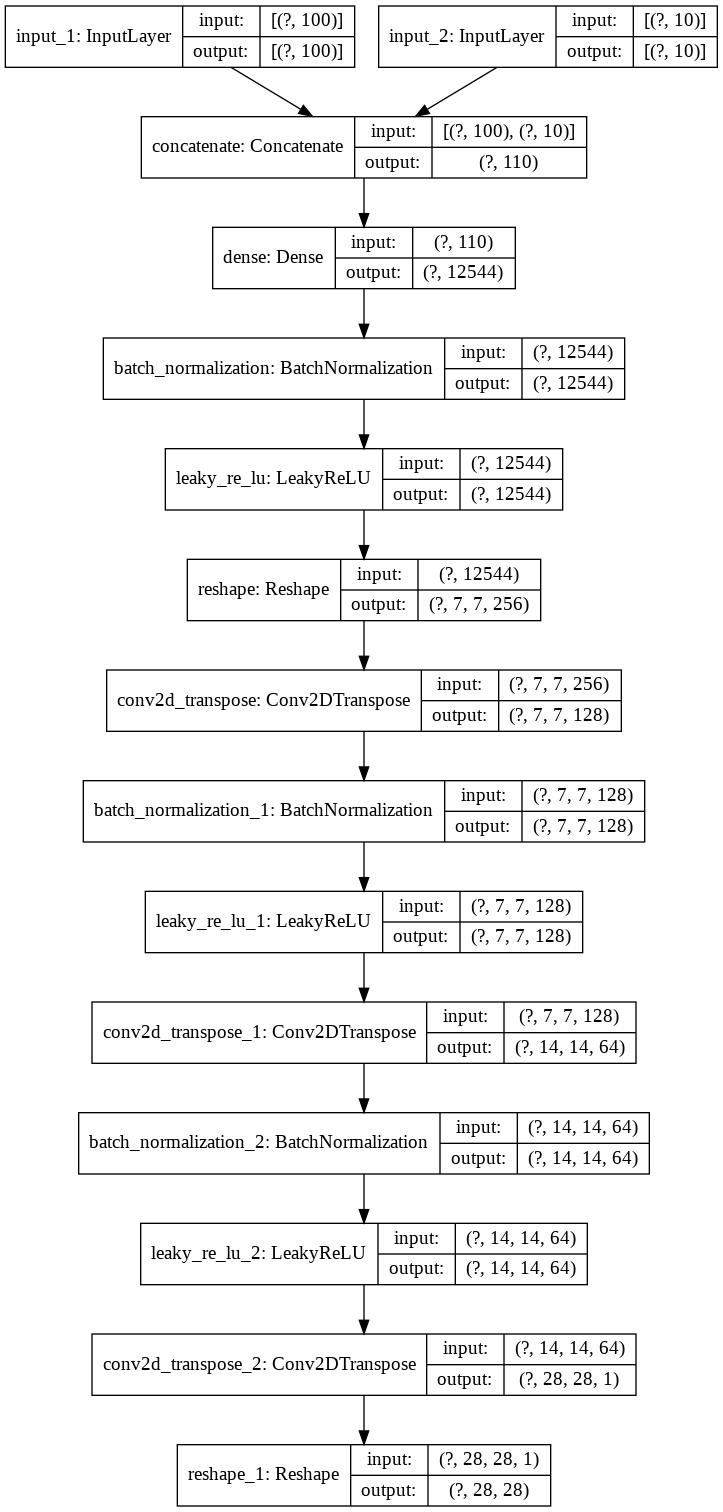

In [0]:
G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)

In [0]:
dec_input = layers.Input(shape=(28,28))
dec_condi = layers.Input(shape=(28,28,10))

dec_res = layers.Reshape(target_shape=(28,28,1))(dec_input)
dec_dense1 = layers.concatenate([dec_res, dec_condi])
dec_dense2 = layers.Conv2D( 64, (5,5), strides=(2,2), padding='same')(dec_dense1)
dec_dense3 = layers.LeakyReLU()(dec_dense2)
dec_dense4 = layers.Dropout(0.3)(dec_dense3)
dec_dense5 = layers.Conv2D( 128, (5,5), strides=(2,2), padding='same')(dec_dense4)
dec_dense6 = layers.LeakyReLU()(dec_dense5)
dec_dense7 = layers.Dropout(0.3)(dec_dense6)
dec_dense8 = layers.Flatten()(dec_dense7)
dec = layers.Dense(1)(dec_dense8)

D = tf.keras.Model(inputs=[dec_input, dec_condi], outputs=dec)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 28, 28, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 28, 28, 10)] 0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 28, 28, 11)   0           reshape_4[0][0]                  
                                                                 input_7[0][0]              

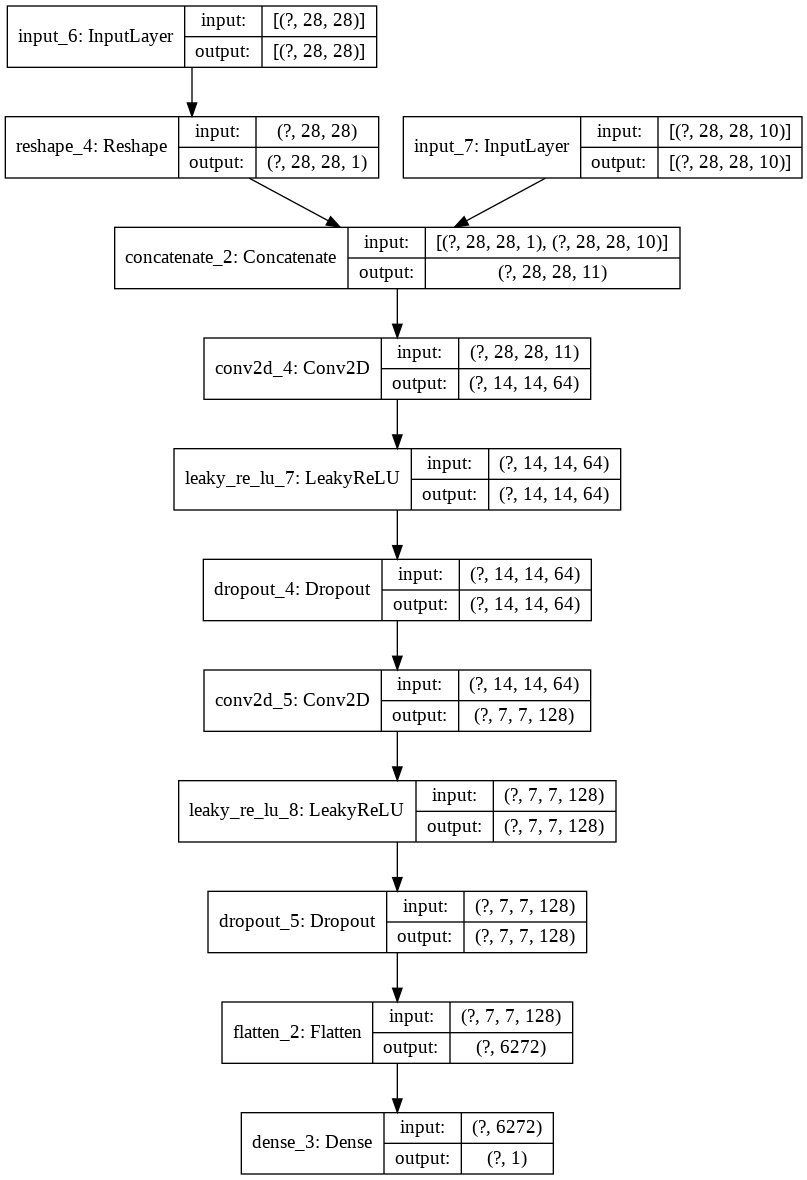

In [0]:
D.summary()
tf.keras.utils.plot_model(D, "discriminator.png", show_shapes=True)

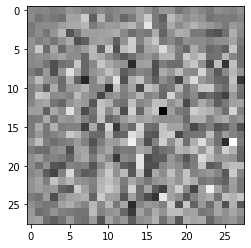

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1, 100])
test_noise_condi = tf.convert_to_tensor([train_label_onehots[0]])
fake_image_test = G([test_noise,test_noise_condi], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test[0], cmap='gray')

In [0]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
test_noise_condi = tf.convert_to_tensor([train_label_onehot[0]])

decision = D([fake_image_test,test_noise_condi], training=False)  # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
print(decision)

tf.Tensor([[0.22216968]], shape=(1, 1), dtype=float32)


In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# 학습 루프 설정

EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images,real_condition):  
  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])
  fake_condition = tf.convert_to_tensor(train_label_onehot[:BATCH_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises,noises_condition], training=True)
    
    real_output = D([real_images,real_condition], training=True)
    fake_output = D([fake_images,fake_condition], training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables)) 

In [0]:
def test_step(real_images, real_condition):  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])
  fake_condition = tf.convert_to_tensor(train_label_onehot[:BATCH_SIZE])

  fake_images = G([noises,noises_condition], training=False)
  
  real_output = D([real_images,real_condition], training=False)
  fake_output = D([fake_images,fake_condition], training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train(dataset,dataset2, epochs):
  for epoch in range(epochs):
    start = time.time()
    i = 0
    for  image_batch, condition_batch in zip(dataset,dataset2):
      train_step(image_batch, condition_batch)
      if i == 0:
        test_step(image_batch, condition_batch)
      i +=1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [0]:
# 학습!!!
%%time
train(train_dataset,train_label_dataset, EPOCHS)

Generator loss: 0.6560339 Discriminator loss: 1.2972417
Time for epoch 1 is 91.46361756324768 sec
Generator loss: 0.010053858 Discriminator loss: 5.2155027
Time for epoch 2 is 88.68848443031311 sec
Generator loss: 0.08405389 Discriminator loss: 3.9664237
Time for epoch 3 is 86.34960556030273 sec
Generator loss: 0.82266784 Discriminator loss: 1.2631483
Time for epoch 4 is 86.84341478347778 sec
Generator loss: 0.68477726 Discriminator loss: 1.4228799
Time for epoch 5 is 86.67259931564331 sec
Generator loss: 1.0049399 Discriminator loss: 0.9552706
Time for epoch 6 is 87.42302012443542 sec
Generator loss: 0.89645445 Discriminator loss: 1.1796699
Time for epoch 7 is 89.39414596557617 sec
Generator loss: 0.7588793 Discriminator loss: 1.4276869
Time for epoch 8 is 87.13146233558655 sec
Generator loss: 0.7134062 Discriminator loss: 1.3617179
Time for epoch 9 is 86.90439343452454 sec
Generator loss: 0.9485482 Discriminator loss: 1.3033956
Time for epoch 10 is 87.2238187789917 sec
Generator loss

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt
import ipywidgets as widgets

noises = tf.random.normal([50, 100])
test_noise_condis = tf.convert_to_tensor(train_label_onehots[:50])
generated_image = G([noises,test_noise_condis], training=False)

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.imshow(generated_image[idx], cmap='gray')
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=50, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=50), Output()), _dom_…

Condition을 삽입하여 작업한 결과 Condition에 맞는 그림이 나오지 않은 모습을 보여주었다. 

50개 전부를 살펴보지는 못했지만 중간에 실제 숫자가 적힌것과 같은 느낌을 주는 사진이 존재했다. 하지만 주어진 Condition과는 다른 모습을 가진 그림이 출력되는 모습을 보았다. 이게 왜 이런지는 모르겠다. 다른거를 전부 살펴 보았는데 사진이 잘 나온 경우에도 Condition에 맞는 사진이 출력된 것을 아직 보지는 못하였다. 

추후에 다른 작업을 해보면서 이러한 결과가 달라지는지 확인해 보고자 한다. 

## Condition Gan Model Generator, Disciminator Dense로 만들기

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 110)          0           input_32[0][0]                   
                                                                 input_33[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 64)           7040        concatenate_15[0][0]      

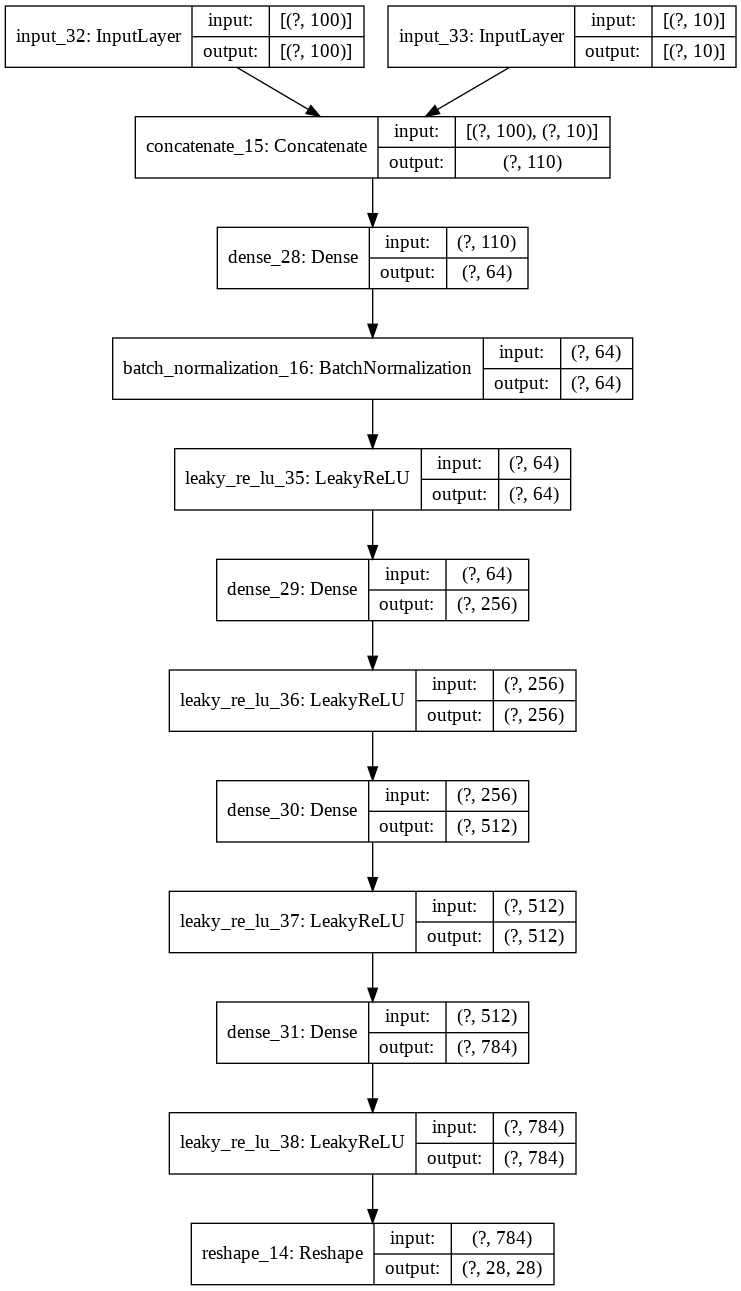

In [0]:
fake_img = tf.keras.Input(shape=(100,)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))

x = tf.keras.layers.concatenate([fake_img, con])
enc_dense_1 = tf.keras.layers.Dense(64, use_bias=False)(x)
enc_dense1 = layers.BatchNormalization()(enc_dense_1)
enc_dense2 = layers.LeakyReLU()(enc_dense1)
enc_dense3 = tf.keras.layers.Dense(256, use_bias=False)(enc_dense2)
# enc_dense4 = layers.BatchNormalization()(enc_dense3)
enc_dense5 = layers.LeakyReLU()(enc_dense3)
enc_dense6 = tf.keras.layers.Dense(512, use_bias=False)(enc_dense5)
# enc_dense7 = layers.BatchNormalization()(enc_dense6)
enc_dense8 = layers.LeakyReLU()(enc_dense6)
enc_dense9 = tf.keras.layers.Dense(784, use_bias=False)(enc_dense8)
# enc_dense10 = layers.BatchNormalization()(enc_dense9)
enc_dense11 = layers.LeakyReLU()(enc_dense9)
enc = layers.Reshape(target_shape=(28,28))(enc_dense11)

G = tf.keras.Model(inputs=[fake_img, con], outputs=enc)

G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 784)          0           input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 794)          0           flatten_10[0][0]                 
                                                                 input_35[0][0]            

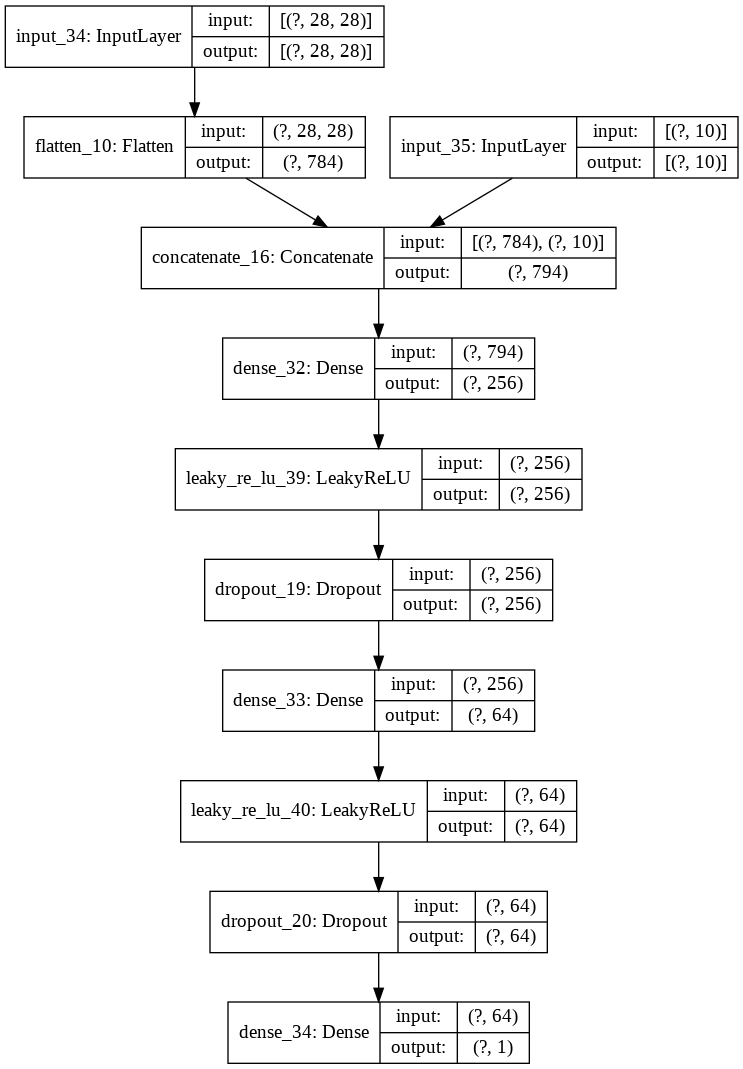

In [0]:
dec_input = layers.Input(shape=(28,28))
dec_condi = layers.Input(shape=(10,))

dec_res = layers.Flatten()(dec_input)
dec_dense1 = layers.concatenate([dec_res, dec_condi])
dec_dense2 = layers.Dense( 256)(dec_dense1)
dec_dense3 = layers.LeakyReLU()(dec_dense2)
dec_dense4 = layers.Dropout(0.3)(dec_dense3)
dec_dense5 = layers.Dense( 64)(dec_dense4)
dec_dense6 = layers.LeakyReLU()(dec_dense5)
dec_dense7 = layers.Dropout(0.3)(dec_dense6)
dec = layers.Dense(1)(dec_dense7)

D = tf.keras.Model(inputs=[dec_input, dec_condi], outputs=dec)

D.summary()
tf.keras.utils.plot_model(D, "discriminator.png", show_shapes=True)

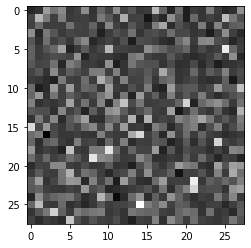

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1, 100])
test_noise_condi = tf.convert_to_tensor([train_label_onehots[0]])
fake_image_test = G([test_noise,test_noise_condi], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test[0], cmap='gray')

In [0]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
test_noise_condi = tf.convert_to_tensor([train_label_onehots[0]])

decision = D([fake_image_test,test_noise_condi], training=False)  # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
print(decision)

tf.Tensor([[-0.07858929]], shape=(1, 1), dtype=float32)


In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# 학습 루프 설정

EPOCHS = 200
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images,real_condition):  
  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises,noises_condition], training=True)
    
    real_output = D([real_images,real_condition], training=True)
    fake_output = D([fake_images,noises_condition], training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables)) 

In [0]:
def test_step(real_images, real_condition):  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])

  fake_images = G([noises,noises_condition], training=False)
  
  real_output = D([real_images,real_condition], training=False)
  fake_output = D([fake_images,noises_condition], training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train(dataset,dataset2, epochs):
  for epoch in range(epochs):
    start = time.time()
    i = 0
    for  image_batch, condition_batch in zip(dataset,dataset2):
      train_step(image_batch, condition_batch)
      if i == 0:
        test_step(image_batch, condition_batch)
      i +=1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [0]:
# 학습!!!
%%time
train(train_dataset,train_label_datasets, EPOCHS)

Generator loss: 0.69187737 Discriminator loss: 0.97665995
Time for epoch 1 is 5.227969169616699 sec
Generator loss: 1.2709688 Discriminator loss: 0.34554335
Time for epoch 2 is 3.4612998962402344 sec
Generator loss: 1.0606729 Discriminator loss: 0.4816575
Time for epoch 3 is 3.4722516536712646 sec
Generator loss: 1.0783464 Discriminator loss: 0.65413594
Time for epoch 4 is 3.38608717918396 sec
Generator loss: 1.389533 Discriminator loss: 0.57392824
Time for epoch 5 is 3.4504616260528564 sec
Generator loss: 1.2745311 Discriminator loss: 0.7494438
Time for epoch 6 is 3.637860059738159 sec
Generator loss: 1.359001 Discriminator loss: 0.5904546
Time for epoch 7 is 3.44909930229187 sec
Generator loss: 0.8818519 Discriminator loss: 0.98868024
Time for epoch 8 is 3.429645299911499 sec
Generator loss: 1.3133658 Discriminator loss: 0.68476933
Time for epoch 9 is 3.3828790187835693 sec
Generator loss: 1.0255299 Discriminator loss: 0.8607789
Time for epoch 10 is 3.3840086460113525 sec
Generator l

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt
import ipywidgets as widgets

noises = tf.random.normal([50, 100])
test_noise_condis = tf.convert_to_tensor(train_label_onehots[:50])
generated_image = G([noises,test_noise_condis], training=False)

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.imshow(generated_image[idx], cmap='gray')
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=50, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=50), Output()), _dom_…

Dense로 모델을 모두 삽입한 결과 기존의 Condition Gan 모델과 비교해 보았을 때 학습에 걸리는 시간이 매우 적었다. 그래서 많은 Epoch를 돌려 작업을 진행하였다. 

하지만 결과 또한 기존의 결과와 매우 유사하였다. 왜인지는 모르겠지만 Condition에 맞지 않는 숫자의 이미지가 출력되는 모습을 보았다. 

이를 통해 어느정도지만 GAN에서는 Condition의 성능이 별로 좋지 않을것 같다는 생각이 들었다. 

Dense를 Condition으로 작업했을 때의 결과를 보고 결론을 내려보고자 한다. 

## Conditional Gan Conv Layer 활용

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 110)          0           input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 1, 1, 110)    0           concatenate_13[0][0]      

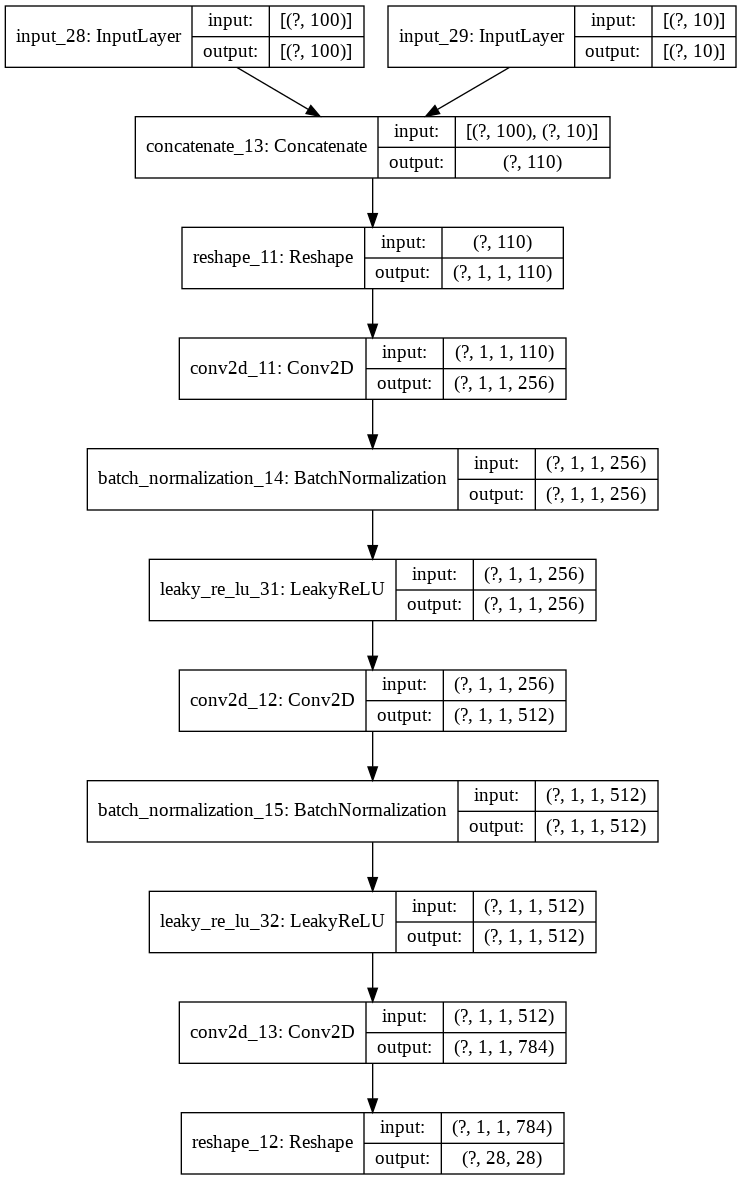

In [0]:
fake_img = tf.keras.Input(shape=(100,)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))

x = tf.keras.layers.concatenate([fake_img, con])

enc_dense3 = layers.Reshape(target_shape=(1, 1, 110))(x)
enc_dense4 = layers.Conv2D(256,(1,1),padding='same',use_bias=False)(enc_dense3)
enc_dense5 = layers.BatchNormalization()(enc_dense4)
enc_dense6 = layers.LeakyReLU()(enc_dense5)
enc_dense7 = layers.Conv2D(512,(1,1),padding='same',use_bias=False)(enc_dense6)
enc_dense8 = layers.BatchNormalization()(enc_dense7)
enc_dense9 = layers.LeakyReLU()(enc_dense8)
enc_dense10 = layers.Conv2D( 784,(1,1),padding='same',use_bias=False, activation='tanh')(enc_dense9)
enc = layers.Reshape(target_shape=(28,28))(enc_dense10)

G = tf.keras.Model(inputs=[fake_img, con], outputs=enc)

G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 28, 28, 1)    0           input_30[0][0]                   
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 28, 28, 10)] 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 28, 28, 11)   0           reshape_13[0][0]                 
                                                                 input_31[0][0]            

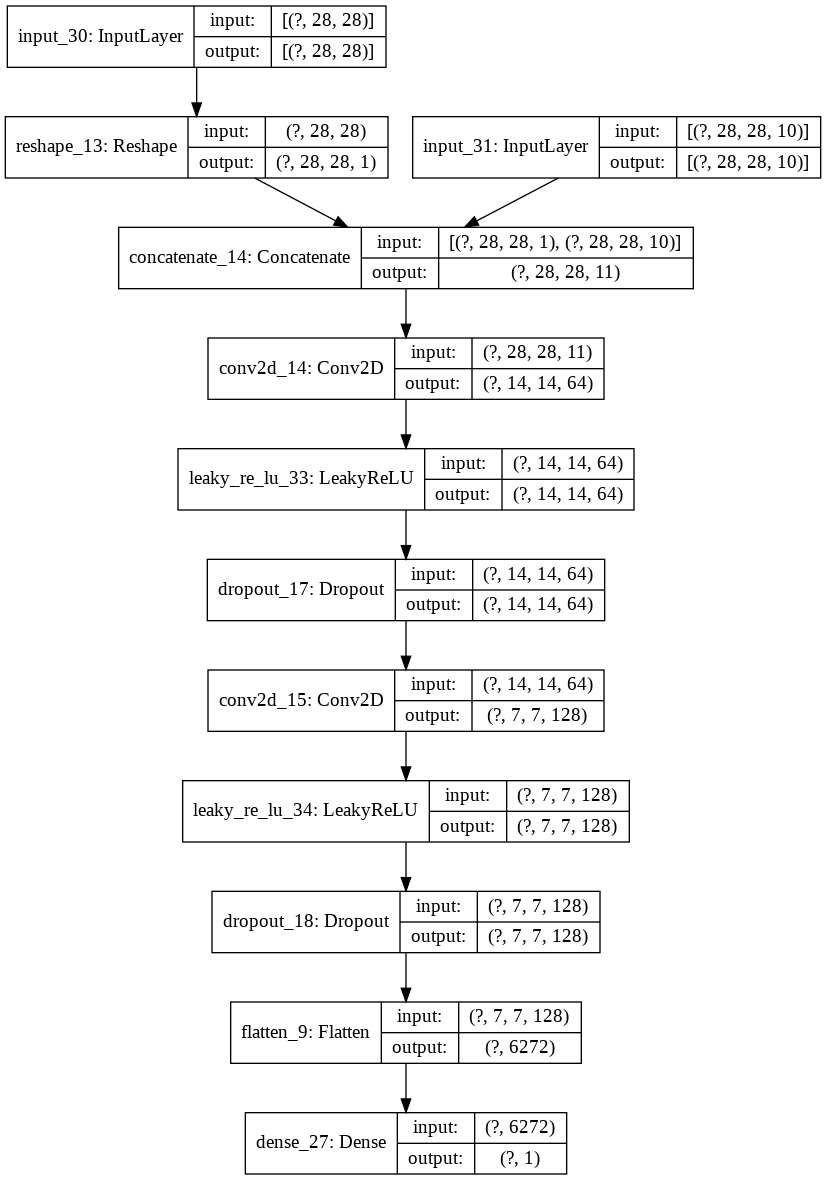

In [0]:
dec_input = layers.Input(shape=(28,28))
dec_condi = layers.Input(shape=(28,28,10))

dec_res = layers.Reshape(target_shape=(28,28,1))(dec_input)
dec_dense1 = layers.concatenate([dec_res, dec_condi])
dec_dense2 = layers.Conv2D( 64, (5,5), strides=(2,2), padding='same')(dec_dense1)
dec_dense3 = layers.LeakyReLU()(dec_dense2)
dec_dense4 = layers.Dropout(0.3)(dec_dense3)
dec_dense5 = layers.Conv2D( 128, (5,5), strides=(2,2), padding='same')(dec_dense4)
dec_dense6 = layers.LeakyReLU()(dec_dense5)
dec_dense7 = layers.Dropout(0.3)(dec_dense6)
dec_dense8 = layers.Flatten()(dec_dense7)
dec = layers.Dense(1)(dec_dense8)

D = tf.keras.Model(inputs=[dec_input, dec_condi], outputs=dec)

D.summary()
tf.keras.utils.plot_model(D, 'discriminator.png', show_shapes=True)

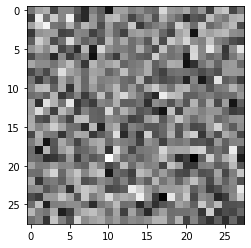

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1, 100])
test_noise_condi = tf.convert_to_tensor([train_label_onehots[0]])
fake_image_test = G([test_noise,test_noise_condi], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test[0], cmap='gray')

In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# 학습 루프 설정

EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images,real_condition):  
  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])
  fake_condition = tf.convert_to_tensor(train_label_onehot[:BATCH_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises,noises_condition], training=True)
    
    real_output = D([real_images,real_condition], training=True)
    fake_output = D([fake_images,fake_condition], training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables)) 

In [0]:
def test_step(real_images, real_condition):  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])
  fake_condition = tf.convert_to_tensor(train_label_onehot[:BATCH_SIZE])

  fake_images = G([noises,noises_condition], training=False)
  
  real_output = D([real_images,real_condition], training=False)
  fake_output = D([fake_images,fake_condition], training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train(dataset,dataset2, epochs):
  for epoch in range(epochs):
    start = time.time()
    i = 0
    for  image_batch, condition_batch in zip(dataset,dataset2):
      train_step(image_batch, condition_batch)
      if i == 0:
        test_step(image_batch, condition_batch)
      i +=1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [0]:
# 학습!!!
%%time
train(train_dataset,train_label_dataset, EPOCHS)

Generator loss: 0.6888865 Discriminator loss: 1.3224226
Time for epoch 1 is 39.79816746711731 sec
Generator loss: 2.6286097 Discriminator loss: 0.30062267
Time for epoch 2 is 36.21311020851135 sec
Generator loss: 2.614853 Discriminator loss: 0.4693422
Time for epoch 3 is 35.790016412734985 sec
Generator loss: 2.7140105 Discriminator loss: 0.26578024
Time for epoch 4 is 35.234368324279785 sec
Generator loss: 2.4318748 Discriminator loss: 0.4927407
Time for epoch 5 is 34.56001162528992 sec
Generator loss: 2.285215 Discriminator loss: 0.47134778
Time for epoch 6 is 36.62499189376831 sec
Generator loss: 2.2942176 Discriminator loss: 0.48568857
Time for epoch 7 is 36.750020027160645 sec
Generator loss: 2.0852604 Discriminator loss: 0.46604973
Time for epoch 8 is 35.868409872055054 sec
Generator loss: 2.119018 Discriminator loss: 0.48388898
Time for epoch 9 is 35.75827980041504 sec
Generator loss: 2.3142858 Discriminator loss: 0.41472912
Time for epoch 10 is 35.92254614830017 sec
Generator l

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt
import ipywidgets as widgets

noises = tf.random.normal([50, 100])
test_noise_condis = tf.convert_to_tensor(train_label_onehots[:50])
generated_image = G([noises,test_noise_condis], training=False)

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.imshow(generated_image[idx], cmap='gray')
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=50, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=50), Output()), _dom_…

Conv로 Gan모델을 학습시켰더니 결과가 굉장히 숫자 그림과 유사하게 나왔다. 

확실히 Discriminator의 경우 Loss의 값이 Dense를 썻을때와 비교해 보았을 때 성능이 훨씬 우수한 모습을 볼 수 있었다. 하지만 모델의 학습에 걸리는 시간이 몇배 차이나는 점이 존재한다.

처음 내가 생각하기에 Conv와 Dense는 학습하는 parameter의 개수부터 차이가 날 것이라 생각했다. 하지만 내가한 방식대로 진행할 경우 두 경우의 parameter의 개수가 똑같은 사실을 알 수 있었다. 하지만 학습에 걸리는 시간이 왜 이렇게 차이나는지에 대하여 알아보아야 할 것 같다. (아마 알고리즘의 차이이지 않을까 싶긴 하다.)

원래 내가 계획한 방식대로라면 주어진 Condition에 맞는 결과가 그림으로 출력이 되어야 하는데 그와 다른 숫자 그림이 출력되는 모습이 이번 실험에서도 나타났다. 이에 대하여 많은 고민을 하였다. 

고민 결과 내가 내린 결론은 Gan 모델을 학습할 때 주어진 Condition에 대하여 판별을 내리는 것이 이것은 실제 사진이다, 사진이 아니다 라는 것이다. 이에 대하여 학습을 진행하기 때문에 주어진 COndition에 맞는 숫자 그림을 만들지 못하는 것이 아닌가 하는것이 나의 결론이다. 

뒤에는 Discriminator에 Condition을 주지 않고 학습을 진행한 후 결과를 분석해보고자 한다.

## Conditional Gan Discriminator condition X

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 110)          0           input_40[0][0]                   
                                                                 input_41[0][0]                   
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 1, 1, 110)    0           concatenate_18[0][0]      

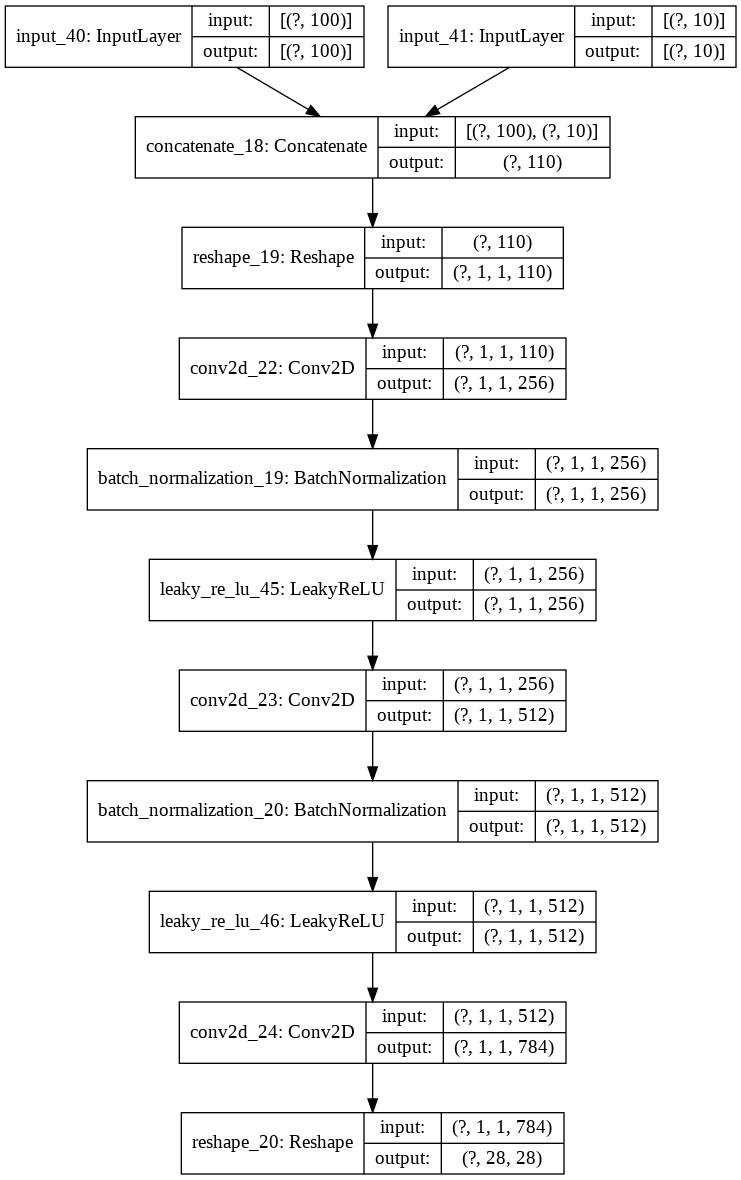

In [0]:
fake_img = tf.keras.Input(shape=(100,)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))

x = tf.keras.layers.concatenate([fake_img, con])

enc_dense3 = layers.Reshape(target_shape=(1, 1, 110))(x)
enc_dense4 = layers.Conv2D(256,(1,1),padding='same',use_bias=False)(enc_dense3)
enc_dense5 = layers.BatchNormalization()(enc_dense4)
enc_dense6 = layers.LeakyReLU()(enc_dense5)
enc_dense7 = layers.Conv2D(512,(1,1),padding='same',use_bias=False)(enc_dense6)
enc_dense8 = layers.BatchNormalization()(enc_dense7)
enc_dense9 = layers.LeakyReLU()(enc_dense8)
enc_dense10 = layers.Conv2D( 784,(1,1),padding='same',use_bias=False, activation='tanh')(enc_dense9)
enc = layers.Reshape(target_shape=(28,28))(enc_dense10)

G = tf.keras.Model(inputs=[fake_img, con], outputs=enc)

G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
reshape_21 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 7, 7, 128)         0  

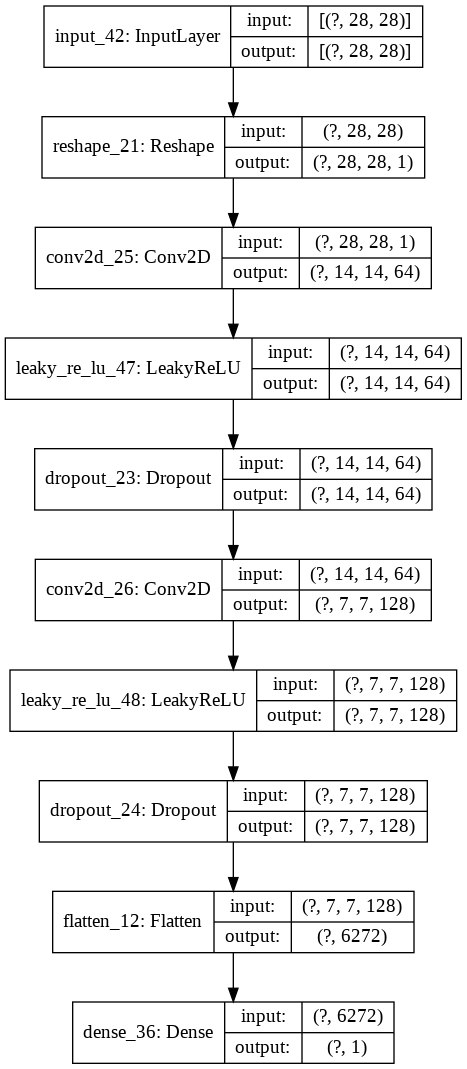

In [0]:
dec_input = layers.Input(shape=(28,28))
# dec_condi = layers.Input(shape=(28,28,10))

dec_res = layers.Reshape(target_shape=(28,28,1))(dec_input)
# dec_dense1 = layers.concatenate([dec_res, dec_condi])
dec_dense2 = layers.Conv2D( 64, (5,5), strides=(2,2), padding='same')(dec_res)
dec_dense3 = layers.LeakyReLU()(dec_dense2)
dec_dense4 = layers.Dropout(0.3)(dec_dense3)
dec_dense5 = layers.Conv2D( 128, (5,5), strides=(2,2), padding='same')(dec_dense4)
dec_dense6 = layers.LeakyReLU()(dec_dense5)
dec_dense7 = layers.Dropout(0.3)(dec_dense6)
dec_dense8 = layers.Flatten()(dec_dense7)
dec = layers.Dense(1)(dec_dense8)

D = tf.keras.Model(inputs=[dec_input], outputs=dec)

D.summary()
tf.keras.utils.plot_model(D, 'discriminator.png', show_shapes=True)

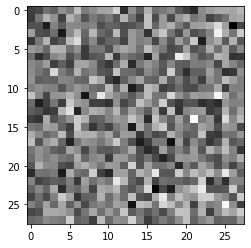

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1, 100])
test_noise_condi = tf.convert_to_tensor([train_label_onehots[0]])
fake_image_test = G([test_noise,test_noise_condi], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test[0], cmap='gray')

In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# 학습 루프 설정

EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images,real_condition):  
  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises,noises_condition], training=True)
    
    real_output = D(real_images, training=True)
    fake_output = D(fake_images, training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables)) 

In [0]:
def test_step(real_images, real_condition):  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  noises_condition = tf.convert_to_tensor(train_label_onehots[:BATCH_SIZE])

  fake_images = G([noises,noises_condition], training=False)
  
  real_output = D(real_images, training=False)
  fake_output = D(fake_images, training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train(dataset,dataset2, epochs):
  for epoch in range(epochs):
    start = time.time()
    i = 0
    for  image_batch, condition_batch in zip(dataset,dataset2):
      train_step(image_batch, condition_batch)
      if i == 0:
        test_step(image_batch, condition_batch)
      i +=1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [0]:
# 학습!!!
%%time
train(train_dataset,train_label_dataset, EPOCHS)

Generator loss: 0.6909606 Discriminator loss: 1.3560691
Time for epoch 1 is 25.66183614730835 sec
Generator loss: 2.146749 Discriminator loss: 0.32103777
Time for epoch 2 is 32.05387353897095 sec
Generator loss: 3.8403478 Discriminator loss: 0.15749863
Time for epoch 3 is 33.85714912414551 sec
Generator loss: 2.275267 Discriminator loss: 0.36038223
Time for epoch 4 is 33.86452865600586 sec
Generator loss: 1.9910936 Discriminator loss: 0.4570175
Time for epoch 5 is 31.385551929473877 sec
Generator loss: 1.8510317 Discriminator loss: 0.47315234
Time for epoch 6 is 34.211429595947266 sec
Generator loss: 1.4193015 Discriminator loss: 0.68297374
Time for epoch 7 is 33.28610849380493 sec
Generator loss: 1.8640897 Discriminator loss: 0.57544696
Time for epoch 8 is 33.20780849456787 sec
Generator loss: 1.6291344 Discriminator loss: 0.62388307
Time for epoch 9 is 33.539340019226074 sec
Generator loss: 1.6284984 Discriminator loss: 0.56763446
Time for epoch 10 is 33.36801886558533 sec
Generator 

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt
import ipywidgets as widgets

noises = tf.random.normal([50, 100])
test_noise_condis = tf.convert_to_tensor(train_label_onehots[:50])
generated_image = G([noises,test_noise_condis], training=False)

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.imshow(generated_image[idx], cmap='gray')
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=50, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=50), Output()), _dom_…

Discriminator에 Condition을 추가하지 않고 작업을 진행해 보았다. 그랫더니 학습에 걸리는 시간이 기존에 비해 많이 감소하였다. 

VAE나 AE의 경우 Condition이 굉장히 많은 역할을 할 수 있었다. 하지만 GAN의 경우 Condition이 실질적으로 모델의 성능에 영향을 미치는지 판단하기에 결과가 좋지 않아 굳이 삽입을 해야 하는가 싶다. 

